In [ ]:
# Import required libraries

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import HTML, display

# Imports for the high pass signal
from scipy.signal import butter, freqz, lfilter

# KFold
from sklearn.model_selection import KFold

# Import required modules
from sklearn.preprocessing import StandardScaler

import os.path

# To write WAV File
from scipy.io.wavfile import write

# To make derivative work on multiple CPUs
from concurrent.futures import ProcessPoolExecutor
from functools import partial

import sys

In [ ]:
# Importing basic functions from other notebooks 
import import_ipynb
from analyze_data_cleaned import compute_symptoms_occurences_dataframe
from analyze_data_cleaned import plot_symptoms_occurences
from analyze_data_cleaned import define_data_type
from analyze_data_cleaned import apply_mask

# to be removed once i know how to import these from another notebook

In [ ]:
def prepro_missing_values(df_train_label):
    """
    Filling NaN values with -1. 
    
    Keyword arguments:
    - df_train_label: DataFrame containing the following columns 
            [measurement_id, subject_id, on_off, tremor, dyskenisia]
    """
    # Replace NaN values with -1.0 because otherwise plotting triggers an error
    df_train_label = df_train_label.fillna(value=-1.0)
    return df_train_label


def compute_symptoms_occurences_dataframe(df_train_label):
    """
    Computes how many times the symptoms are occuring for a single subject_id 
    
    Keyword arguments:
    - df_train_label: DataFrame containing the following columns 
            [measurement_id, subject_id, on_off, tremor, dyskenisia]
    """
    df_train_label = prepro_missing_values(df_train_label=df_train_label)

    # Group data by subject_id
    df_train_label_subject_id = df_train_label.groupby("subject_id")

    df_occurences = []
    symptoms = ["on_off", "dyskinesia", "tremor"]

    for key, value in df_train_label_subject_id:
        for symptom in symptoms:
            # Pour un patient, prendre les 3 dernieres colonnes, et pour 1 symptome, calculer le nb d'occurences
            counter = (
                df_train_label_subject_id.get_group(key)
                .iloc[:, -3:][symptom]
                .value_counts()
            )

            for symptom_value, symptom_occurence in counter.items():
                df_occurences.append(
                    (
                        {
                            "subject_id": key,
                            "symptom": symptom,
                            "symptom_value": symptom_value,
                            "occurence": symptom_occurence,
                        }
                    )
                )

    df_occurences = pd.DataFrame(
        df_occurences, columns=("subject_id", "symptom", "symptom_value", "occurence")
    )

    return df_occurences, df_train_label_subject_id

In [ ]:
# Source: https://stackoverflow.com/questions/28931224/adding-value-labels-on-a-matplotlib-bar-chart
def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.1f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.

In [ ]:
def plot_symptoms_occurences(df_occurences, df_train_label_subject_id):
    """
    This function plots the occurences of symptoms according to subject_id 

    Keyword Arguments: 
    - df_occurences: contains the df with occurences computed in compute_symptoms_occurences_dataframe
    - df_train_label_subject_id: contains df_train_label grouped by subject_id 
    """

    # There will be one graph plotted for each patient, for each of the 3 symptoms
    nb_subjects_id = (
        df_occurences.subject_id.nunique()
    )  # nb of unique patients in the label file
    print("Nb subject_id : ", nb_subjects_id)
    height = 30 if nb_subjects_id > 10 else 5
    fig, axes = plt.subplots(
        nrows=nb_subjects_id, ncols=3, figsize=(10, height), sharey=True
    )  # 3 cols for the 3 symptoms

    # Quick fix to plot the graphs at the right place. Starts at -1 because in the first for loop
    # it is incremented
    patient = -1
    
    # Plot for all subject_id 3 bar plots for all the symptoms and their occurences
    # Reminder that NaN values (missing values) were replaced with -1 and are shown as such in the plots
    symptoms = ["on_off", "dyskinesia", "tremor"]
    for key, value in df_train_label_subject_id:
        patient = patient + 1  # value used to position the plots (row)
        symptom_no = 0  # value only used to position the plots (col)
        for symptom in symptoms:

            subject_symptom = " ".join(
                [str(key), symptom]
            )  # variable used to create a title for each plot

            ax = df_train_label_subject_id.get_group(key)[symptom].value_counts().plot(
                kind="bar",
                x=symptom,
                title=subject_symptom,
                ax=axes[symptom_no],
                sharey=True,
            )
            fig.tight_layout()
            plt.tight_layout()
            symptom_no = symptom_no + 1
            add_value_labels(ax)
        plt.show()
            

In [ ]:
# inspired by "plot traces per subject"
# Source: https://machinelearningmastery.com/how-to-load-and-explore-a-standard-human-activity-recognition-problem/
from matplotlib import pyplot

# Define the data type as we have two databases
data_type = "cis"
training_or_ancillary = 'training_data'
path_train_data, df_train_label = define_data_type(data_type=data_type)
    
def plot_subjects(df_train_label):
    fig, ax = pyplot.subplots(figsize=(30, 30))
    for idx in df_train_label.index:
        if idx == 10:
            break
        print('idx : ', str(idx))
        pyplot.subplot(10, 1, idx+1)
        df_train_data = pd.read_csv(path_train_data + df_train_label["measurement_id"][idx] + ".csv")
        pyplot.plot(df_train_data.iloc[:,-4], df_train_data.iloc[:,-1], '-b', label='Z')
        pyplot.plot(df_train_data.iloc[:,-4], df_train_data.iloc[:,-3], '-g', label='X')
        pyplot.plot(df_train_data.iloc[:,-4], df_train_data.iloc[:,-2], '-m', label='Y')
    pyplot.legend()
    pyplot.tight_layout()
    pyplot.show()

plot_subjects(df_train_label)

### Visualisation with inactivity removed

In [ ]:
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype="high", analog=False)
    return b, a


def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def test(df_train_data):
    # Filter requirements.
    order = 10
    fs = 50.0  # sample rate, Hz
    cutoff = 0.5  # 3.667  # desired cutoff frequency of the filter, Hz
    
    # Get the filter coefficients so we can check its frequency response.
    b, a = butter_highpass(cutoff, fs, order)
    
    X_filtered_data = butter_highpass_filter(df_train_data.iloc[:,-3], cutoff, fs, order)
    Y_filtered_data = butter_highpass_filter(df_train_data.iloc[:,-2], cutoff, fs, order)
    Z_filtered_data = butter_highpass_filter(df_train_data.iloc[:,-1], cutoff, fs, order)
    
    return X_filtered_data, Y_filtered_data, Z_filtered_data

In [ ]:
def plot_subjects(df_train_label):
    fig, ax = pyplot.subplots(figsize=(30, 30))
    for idx in df_train_label.index:
        if idx == 10:
            break
        print('idx : ', str(idx))
        pyplot.subplot(10, 1, idx+1)
        df_train_data = apply_mask(df_train_label["measurement_id"][idx], 
                                   mask_path='/home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.high_pass_mask/')
        print(len(df_train_data))
        #         df_train_data = pd.read_csv(path_train_data + df_train_label["measurement_id"][idx] + ".csv")
        X_filtered_data, Y_filtered_data, Z_filtered_data = test(df_train_data)
        
        pyplot.plot(df_train_data.iloc[:,-4], X_filtered_data, '-b', label='Z')
        pyplot.plot(df_train_data.iloc[:,-4], Y_filtered_data, '-g', label='X')
        pyplot.plot(df_train_data.iloc[:,-4], Z_filtered_data, '-m', label='Y')
    pyplot.legend()
    pyplot.tight_layout()
    pyplot.show()
    
plot_subjects(df_train_label)

### Analyze the kfold distribution V1

In [ ]:
data_type = "cis"
data_real_subtype=""

if data_type == "cis":
    kfold_path = "/home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.k_fold_v1/"

data_path = "/home/sjoshi/codes/python/BeatPD/data/BeatPD/"
data_path = data_path + data_type + "-pd.training_data/" + data_real_subtype + "/"

nb_folds = np.array([0,1,2,3,4])

pids = np.array([1004,1006,1007,1019,1020,1023,1032,1034,1038,1039,1043,1044,1046,1048,1049,1051])

for temp_pid in pids:
    for nb in nb_folds:
        for train_or_test in ['train','test']:
            file_name = str(temp_pid) + '_'+train_or_test+'_kfold_' + str(nb) + '.csv'
            print(file_name)
            df_train_label = pd.read_csv(kfold_path+file_name)
            # Compute the occurences of each symptoms for each patient

            df_occurences, df_train_label_subject_id = compute_symptoms_occurences_dataframe(
                df_train_label=df_train_label
            )

            # Plot the graphs
            plot_symptoms_occurences(
                df_occurences=df_occurences, df_train_label_subject_id=df_train_label_subject_id
            )

            #print(df_train_label.values[:,1:])
            #temp_train_X = pd.read_csv(data_path+df_train_label["measurement_id"][idx] + '.csv')

In [ ]:
df_occurences, df_train_label_subject_id

### Analyze the kfold distribution V2

In [ ]:
data_type = "cis"
data_real_subtype=""

if data_type == "cis":
    kfold_path = "/home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.k_fold_v2/"

data_path = "/home/sjoshi/codes/python/BeatPD/data/BeatPD/"
data_path = data_path + data_type + "-pd.training_data/" + data_real_subtype + "/"

nb_folds = np.array([0,1,2,3,4])

# pids = np.array([1038])
pids = np.array([1004,1006,1007,1019,1020,1023,1032,1034,1038,1039,1043,1044,1046,1048,1049,1051])

for temp_pid in pids:
    for nb in nb_folds:
        for train_or_test in ['train','test']:
            file_name = str(temp_pid) + '_'+train_or_test+'_kfold_' + str(nb) + '.csv'
            print(file_name)
            df_train_label = pd.read_csv(kfold_path+file_name)
            # Compute the occurences of each symptoms for each patient

            df_occurences, df_train_label_subject_id = compute_symptoms_occurences_dataframe(
                df_train_label=df_train_label
            )

            # Plot the graphs
            plot_symptoms_occurences(
                df_occurences=df_occurences, df_train_label_subject_id=df_train_label_subject_id
            )

            #print(df_train_label.values[:,1:])
            #temp_train_X = pd.read_csv(data_path+df_train_label["measurement_id"][idx] + '.csv')

# CIS Database

## Distribution of the length of the files

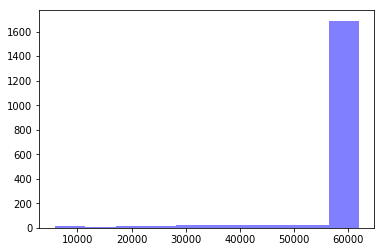

min :  5803
max :  61960


In [117]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

data_type = "cis"

path_train_data, df_train_label = define_data_type(data_type=data_type)

len_distribution = []
for idx in df_train_label.index:
        df_train_data = pd.read_csv(path_train_data + df_train_label["measurement_id"][idx] + ".csv")
        len_distribution.append(len(df_train_data))


num_bins = 10
n, bins, patches = plt.hist(len_distribution, num_bins, facecolor='blue', alpha=0.5)
plt.show()

print('min : ', min(len_distribution))
print('max : ', max(len_distribution))

# REAL-PD Database

## Distribution of the length of the files

smartphone_accelerometer


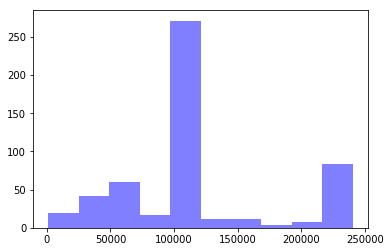

smartwatch_accelerometer


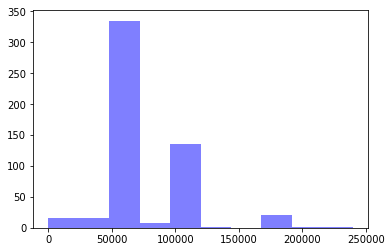

smartwatch_gyroscope


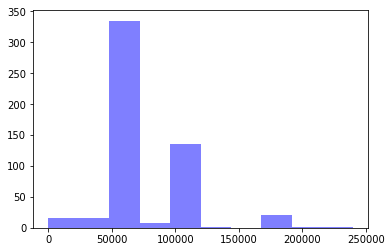

In [118]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

data_type = "real"
training_or_ancillary='training_data'
data_real_subtype='smartphone_accelerometer'

for data_real_subtype in ['smartphone_accelerometer','smartwatch_accelerometer','smartwatch_gyroscope']:
    path_train_data, df_train_label = define_data_type(data_type, training_or_ancillary, data_real_subtype)

    len_distribution = []

    for idx in df_train_label.index:
        try:
            df_train_data = pd.read_csv(path_train_data + df_train_label["measurement_id"][idx] + ".csv")
            len_distribution.append(len(df_train_data))
        except FileNotFoundError:
            continue
    print(data_real_subtype)
    num_bins = 10
    n, bins, patches = plt.hist(len_distribution, num_bins, facecolor='blue', alpha=0.5)
    plt.show()
